In [1]:
#!/usr/bin/python3
import numpy as np

def ortho(vect2d):
    """Computes an orthogonal vector to the one given"""
    return np.array((-vect2d[1], vect2d[0]))

def dist(pt_a, pt_b):
    """Euclidian distance between two (x, y) points"""
    return ((pt_a[0]-pt_b[0])**2 + (pt_a[1]-pt_b[1])**2)**.5

class Dubins:
    """
    Class implementing a Dubins path planner with a constant turn radius.

    Attributes
    ----------
    radius : float
        The radius of the turn used in all the potential trajectories.
    point_separation : float
        The distance between points of the trajectories. More points increases
        the precision of the path but also augments the computation time of the
        colision check.

    Methods
    -------
    dubins_path
        Computes the shortest dubins path between two given points.
    generate_points_straight
        Turns a path into a set of point representing the trajectory, for
        dubins paths when the path is one of LSL, LSR, RSL, RSR.
    generate_points_curve
        Turns a path into a set of point representing the trajectory, for
        dubins paths when the path is one of RLR or LRL.
    find_center
        Compute the center of the circle described by a turn.
    lsl
        Dubins path with a left straight left trajectory.
    rsr
        Dubins path with a right straight right trajectory.
    rsl
        Dubins path with a right straight left trajectory.
    lsr
        Dubins path with a left straight right trajectory.
    lrl
        Dubins path with a left right left trajectory.
    rlr
        Dubins path with a right left right trajectory.
    """
    def __init__(self, radius, point_separation):
        assert radius > 0 and point_separation > 0
        self.radius = radius
        self.point_separation = point_separation

    def all_options(self, start, end, sort=False):
        """
        Computes all the possible Dubin's path and returns them, in the form
        of a list of tuples representing each option: (path_length,
        dubins_path, straight).

        Parameters
        ----------
        start :  tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the inital point.
        end : tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the final point.
        sort : bool
            If the list of option has to be sorted by decreasing cost or not.

        Returns
        -------
        The shortest list of points (x, y) linking the initial and final points
        given as input with only turns of a defined radius and straight line.

        """
        center_0_left = self.find_center(start, 'L')
        center_0_right = self.find_center(start, 'R')
        center_2_left = self.find_center(end, 'L')
        center_2_right = self.find_center(end, 'R')
        options = [self.lsl(start, end, center_0_left, center_2_left),
                   self.rsr(start, end, center_0_right, center_2_right),
                   self.rsl(start, end, center_0_right, center_2_left),
                   self.lsr(start, end, center_0_left, center_2_right),
                   self.rlr(start, end, center_0_right, center_2_right),
                   self.lrl(start, end, center_0_left, center_2_left)]
        if sort:
            options.sort(key=lambda x: x[0])
        return options

    def dubins_path(self, start, end):
        """
        Computes all the possible Dubin's path and returns the sequence of
        points representing the shortest option.

        Parameters
        ----------
        start :  tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the inital point.
        end : tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the final point.

        Returns
        -------
        The shortest list of points (x, y) linking the initial and final points
        given as input with only turns of a defined radius and straight line.
        In the form of a (2xn) numpy array.

        """
        options = self.all_options(start, end)
        dist, dubins_path, straight = min(options, key=lambda x: x[0])
        return self.generate_points(start, end, dubins_path, straight), dist

    def generate_points(self, start, end, dubins_path, straight):
        """
        Transforms the dubins path in a succession of points in the 2D plane.

        Parameters
        ----------
        start: tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the inital point.
        end: tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the final point.
        dubins_path: tuple
            The representation of the dubins path in the form of a tuple
            containing:
                - the angle of the turn in the first circle, in rads.
                - the angle of the turn in the last circle, in rads.
                - the angle of the turn in the central circle, in rads, or the
                  length of the central segment if straight is true.
        straight: bool
            True if their is a central segment in the dubins path.

        Returns
        -------
        The shortest list of points (x, y) linking the initial and final points
        given as input with only turns of a defined radius and straight line.
        In the form of a (2xn) numpy array.

        """
        if straight:
            return self.generate_points_straight(start, end, dubins_path)
        return self.generate_points_curve(start, end, dubins_path)

    def lsl(self, start, end, center_0, center_2):
        """
        Left-Straight-Left trajectories.
        First computes the poisition of the centers of the turns, and then uses
        the fact that the vector defined by the distance between the centers
        gives the direction and distance of the straight segment.

        .. image:: img/twoturnssame.svg

        Parameters
        ----------
        start : tuple
            (x, y, psi) coordinates of the inital point.
        end : tuple
            (x, y, psi) coordinates of the final point.
        center_0 : tuple
            (x, y) coordinates of the center of the first turn.
        center_2 : tuple
            (x, y) coordinates of the center of the last turn.

        Returns
        -------
        total_len : float
            The total distance of this path.
        (beta_0, beta_2, straight_dist) : tuple
            The dubins path, i.e. the angle of the first turn, the angle of the
            last turn, and the length of the straight segment.
        straight : bool
            True, to indicate that this path contains a straight segment.
        """
        straight_dist = dist(center_0, center_2)
        alpha = np.arctan2((center_2-center_0)[1], (center_2-center_0)[0])
        beta_2 = (end[2]-alpha)%(2*np.pi)
        beta_0 = (alpha-start[2])%(2*np.pi)
        total_len = self.radius*(beta_2+beta_0)+straight_dist
        return (total_len, (beta_0, beta_2, straight_dist), True)

    def rsr(self, start, end, center_0, center_2):
        """
        Right-Straight-Right trajectories.
        First computes the poisition of the centers of the turns, and then uses
        the fact that the vector defined by the distance between the centers
        gives the direction and distance of the straight segment.

        .. image:: img/twoturnssame.svg

        Parameters
        ----------
        start : tuple
            (x, y, psi) coordinates of the inital point.
        end : tuple
            (x, y, psi) coordinates of the final point.
        center_0 : tuple
            (x, y) coordinates of the center of the first turn.
        center_2 : tuple
            (x, y) coordinates of the center of the last turn.

        Returns
        -------
        total_len : float
            The total distance of this path.
        (beta_0, beta_2, straight_dist) : tuple
            The dubins path, i.e. the angle of the first turn, the angle of the
            last turn, and the length of the straight segment.
        straight : bool
            True, to indicate that this path contains a straight segment.

        """
        straight_dist = dist(center_0, center_2)
        alpha = np.arctan2((center_2-center_0)[1], (center_2-center_0)[0])
        beta_2 = (-end[2]+alpha)%(2*np.pi)
        beta_0 = (-alpha+start[2])%(2*np.pi)
        total_len = self.radius*(beta_2+beta_0)+straight_dist
        return (total_len, (-beta_0, -beta_2, straight_dist), True)

    def rsl(self, start, end, center_0, center_2):
        """
        Right-Straight-Left trajectories.
        Because of the change in turn direction, it is a little more complex to
        compute than in the RSR or LSL cases. First computes the position of
        the centers of the turns, and then uses the rectangle triangle defined
        by the point between the two circles, the center point of one circle
        and the tangeancy point of this circle to compute the straight segment
        distance.

        .. image:: img/twoturnsopposite.svg

        Parameters
        ----------
        start : tuple
            (x, y, psi) coordinates of the inital point.
        end : tuple
            (x, y, psi) coordinates of the final point.
        center_0 : tuple
            (x, y) coordinates of the center of the first turn.
        center_2 : tuple
            (x, y) coordinates of the center of the last turn.

        Returns
        -------
        total_len : float
            The total distance of this path.
        (beta_0, beta_2, straight_dist) : tuple
            The dubins path, i.e. the angle of the first turn, the angle of the
            last turn, and the length of the straight segment.
        straight : bool
            True, to indicate that this path contains a straight segment.

        """
        median_point = (center_2 - center_0)/2
        psia = np.arctan2(median_point[1], median_point[0])
        half_intercenter = np.linalg.norm(median_point)
        if half_intercenter < self.radius:
            return (float('inf'), (0, 0, 0), True)
        alpha = np.arccos(self.radius/half_intercenter)
        beta_0 = -(psia+alpha-start[2]-np.pi/2)%(2*np.pi)
        beta_2 = (np.pi+end[2]-np.pi/2-alpha-psia)%(2*np.pi)
        straight_dist = 2*(half_intercenter**2-self.radius**2)**.5
        total_len = self.radius*(beta_2+beta_0)+straight_dist
        return (total_len, (-beta_0, beta_2, straight_dist), True)

    def lsr(self, start, end, center_0, center_2):
        """
        Left-Straight-Right trajectories.
        Because of the change in turn direction, it is a little more complex to
        compute than in the RSR or LSL cases. First computes the poisition of
        the centers of the turns, and then uses the rectangle triangle defined
        by the point between the two circles, the center point of one circle
        and the tangeancy point of this circle to compute the straight segment
        distance.

        .. image:: img/twoturnsopposite.svg

        Parameters
        ----------
        start : tuple
            (x, y, psi) coordinates of the inital point.
        end : tuple
            (x, y, psi) coordinates of the final point.
        center_0 : tuple
            (x, y) coordinates of the center of the first turn.
        center_2 : tuple
            (x, y) coordinates of the center of the last turn.

        Returns
        -------
        total_len : float
            The total distance of this path.
        (beta_0, beta_2, straight_dist) : tuple
            The dubins path, i.e. the angle of the first turn, the angle of the
            last turn, and the length of the straight segment.
        straight : bool
            True, to indicate that this path contains a straight segment.

            """
        median_point = (center_2 - center_0)/2
        psia = np.arctan2(median_point[1], median_point[0])
        half_intercenter = np.linalg.norm(median_point)
        if half_intercenter < self.radius:
            return (float('inf'), (0, 0, 0), True)
        alpha = np.arccos(self.radius/half_intercenter)
        beta_0 = (psia-alpha-start[2]+np.pi/2)%(2*np.pi)
        beta_2 = (.5*np.pi-end[2]-alpha+psia)%(2*np.pi)
        straight_dist = 2*(half_intercenter**2-self.radius**2)**.5
        total_len = self.radius*(beta_2+beta_0)+straight_dist
        return (total_len, (beta_0, -beta_2, straight_dist), True)

    def lrl(self, start, end, center_0, center_2):
        """
        Left-right-Left trajectories.
        Using the isocele triangle made by the centers of the three circles,
        computes the required angles.

        .. image:: img/threeturns.svg

        Parameters
        ----------
        start : tuple
            (x, y, psi) coordinates of the inital point.
        end : tuple
            (x, y, psi) coordinates of the final point.
        center_0 : tuple
            (x, y) coordinates of the center of the first turn.
        center_2 : tuple
            (x, y) coordinates of the center of the last turn.

        Returns
        -------
        total_len : float
            The total distance of this path.
        (beta_0, beta_2, straight_dist) : tuple
            The dubins path, i.e. the angle of the first turn, the angle of the
            last turn, and the length of the straight segment.
        straight : bool
            False, to indicate that this path does not contain a straight part.
        """
        dist_intercenter = dist(center_0, center_2)
        intercenter = (center_2 - center_0)/2
        psia = np.arctan2(intercenter[1], intercenter[0])
        if 2*self.radius < dist_intercenter > 4*self.radius:
            return (float('inf'), (0, 0, 0), False)
        gamma = 2*np.arcsin(dist_intercenter/(4*self.radius))
        beta_0 = (psia-start[2]+np.pi/2+(np.pi-gamma)/2)%(2*np.pi)
        beta_1 = (-psia+np.pi/2+end[2]+(np.pi-gamma)/2)%(2*np.pi)
        total_len = (2*np.pi-gamma+abs(beta_0)+abs(beta_1))*self.radius
        return (total_len,
                (beta_0, beta_1, 2*np.pi-gamma),
                False)

    def rlr(self, start, end, center_0, center_2):
        """
        Right-left-right trajectories.
        Using the isocele triangle made by the centers of the three circles,
        computes the required angles.

        .. image:: img/threeturns.svg

        Parameters
        ----------
        start : tuple
            (x, y, psi) coordinates of the inital point.
        end : tuple
            (x, y, psi) coordinates of the final point.
        center_0 : tuple
            (x, y) coordinates of the center of the first turn.
        center_2 : tuple
            (x, y) coordinates of the center of the last turn.

        Returns
        -------
        total_len : float
            The total distance of this path.
        (beta_0, beta_2, straight_dist) : tuple
            The dubins path, i.e. the angle of the first turn, the angle of the
            last turn, and the length of the straight segment.
        straight : bool
            False, to indicate that this path does not contain a straight part.
        """
        dist_intercenter = dist(center_0, center_2)
        intercenter = (center_2 - center_0)/2
        psia = np.arctan2(intercenter[1], intercenter[0])
        if 2*self.radius < dist_intercenter > 4*self.radius:
            return (float('inf'), (0, 0, 0), False)
        gamma = 2*np.arcsin(dist_intercenter/(4*self.radius))
        beta_0 = -((-psia+(start[2]+np.pi/2)+(np.pi-gamma)/2)%(2*np.pi))
        beta_1 = -((psia+np.pi/2-end[2]+(np.pi-gamma)/2)%(2*np.pi))
        total_len = (2*np.pi-gamma+abs(beta_0)+abs(beta_1))*self.radius
        return (total_len,
                (beta_0, beta_1, 2*np.pi-gamma),
                False)


    def find_center(self, point, side):
        """
        Given an initial position, and the direction of the turn, computes the
        center of the circle with turn radius self.radius passing by the intial
        point.

        Parameters
        ----------
        point : tuple
            In the form (x, y, psi), with psi in radians.
            The representation of the inital point.
        side : Char
            Either 'L' to indicate a left turn, or 'R' for a right turn.

        Returns
        -------
        coordinates : 2x1 Array Like
            Coordinates of the center of the circle describing the turn.

        """
        assert side in 'LR'
        angle = point[2] + (np.pi/2 if side == 'L' else -np.pi/2)
        return np.array((point[0] + np.cos(angle)*self.radius,
                         point[1] + np.sin(angle)*self.radius))

    def generate_points_straight(self, start, end, path):
        """
        For the 4 first classes of dubins paths, containing in the middle a
        straight section.

        Parameters
        ----------
        start : tuple
            Start position in the form (x, y, psi).
        end : tuple
            End position in the form (x, y, psi).
        path : tuple
            The computed dubins path, a tuple containing:
                - the angle of the turn in the first circle, in rads
                - the angle of the turn in the last circle, in rads
                - the length of the straight line in between
            A negative angle means a right turn (antitrigonometric), and a
            positive angle represents a left turn.

        Returns
        -------
        The shortest list of points (x, y) linking the initial and final points
        given as input with only turns of a defined radius and straight line.
        In the form of a (2xn) numpy array.

        """
        total = self.radius*(abs(path[1])+abs(path[0]))+path[2] # Path length
        center_0 = self.find_center(start, 'L' if path[0] > 0 else 'R')
        center_2 = self.find_center(end, 'L' if path[1] > 0 else 'R')

        # We first need to find the points where the straight segment starts
        if abs(path[0]) > 0:
            angle = start[2]+(abs(path[0])-np.pi/2)*np.sign(path[0])
            ini = center_0+self.radius*np.array([np.cos(angle), np.sin(angle)])
        else: ini = np.array(start[:2])
        # We then identify its end
        if abs(path[1]) > 0:
            angle = end[2]+(-abs(path[1])-np.pi/2)*np.sign(path[1])
            fin = center_2+self.radius*np.array([np.cos(angle), np.sin(angle)])
        else: fin = np.array(end[:2])
        dist_straight = dist(ini, fin)

        # We can now generate all the points with the desired precision
        points = []
        straight_pint=False
        for x in np.arange(0, total, self.point_separation):
            if x < abs(path[0])*self.radius: # First turn
                points.append(self.circle_arc(start, path[0], center_0, x))
            elif x > total - abs(path[1])*self.radius: # Last turn
                points.append(self.circle_arc(end, path[1], center_2, x-total))
            else: # Straight segment
                    coeff = (x-abs(path[0])*self.radius)/dist_straight
                    points.append(coeff*fin + (1-coeff)*ini)
        points.append(end[:2])
        return np.array(points)

    def generate_points_curve(self, start, end, path):
        """
        For the two last paths, where the trajectory is a succession of 3
        turns. First computing the position of the center of the central turn,
        then using the three circles to apply the angles given in the path
        argument.

        Parameters
        ----------
        start : tuple
            Start position in the form (x, y, psi).
        end : tuple
            End position in the form (x, y, psi).
        path : tuple
            The computed dubins path, a tuple containing:
                - the angle of the turn in the first circle, in rads
                - the angle of the turn in the last circle, in rads
                - the angle of the turn in the central circle, in rads
            A negative angle means a right turn (antitrigonometric), and a
            positive angle represents a left turn.

        Returns
        -------
        The shortest list of points (x, y) linking the initial and final points
        given as input with only turns of a defined radius. In the form of a
        (2xn) numpy array.

        """
        total = self.radius*(abs(path[1])+abs(path[0])+abs(path[2]))
        center_0 = self.find_center(start, 'L' if path[0] > 0 else 'R')
        center_2 = self.find_center(end, 'L' if path[1] > 0 else 'R')
        intercenter = dist(center_0, center_2)
        center_1 = (center_0 + center_2)/2 +\
                   np.sign(path[0])*ortho((center_2-center_0)/intercenter)\
                    *(4*self.radius**2-(intercenter/2)**2)**.5
        psi_0 = np.arctan2((center_1 - center_0)[1],
                           (center_1 - center_0)[0])-np.pi

        points = []
        for x in np.arange(0, total, self.point_separation):
            if x < abs(path[0])*self.radius: # First turn
                points.append(self.circle_arc(start, path[0], center_0, x))
            elif x > total - abs(path[1])*self.radius: # Last turn
                points.append(self.circle_arc(end, path[1], center_2, x-total))
            else: # Middle Turn
                angle = psi_0-np.sign(path[0])*(x/self.radius-abs(path[0]))
                vect = np.array([np.cos(angle), np.sin(angle)])
                points.append(center_1+self.radius*vect)
        points.append(end[:2])
        return np.array(points)

    def circle_arc(self, reference, beta, center, x):
        """
        Returns the point located on the circle of center center and radius
        defined by the class, at the angle x.

        Parameters
        ----------
        reference : float
            Angular starting point, in radians.
        beta : float
            Used actually only to know the direction of the rotation, and hence
            to know if the path needs to be added or substracted from the
            reference angle.
        center : tuple
            (x, y) coordinates of the center of the circle from which we need a
            point on the circumference.
        x : float
            The lenght of the path on the circle.

        Returns
        -------
        The coordinates of the point on the circle, in the form of a tuple.
        """
        angle = reference[2]+((x/self.radius)-np.pi/2)*np.sign(beta)
        vect = np.array([np.cos(angle), np.sin(angle)])
        return center+self.radius*vect

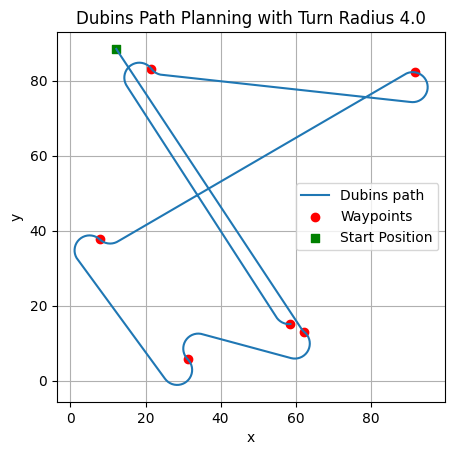

path length 470.14149998466905
time 470.14149998466905


In [5]:
import numpy as np
import matplotlib.pyplot as plt


class WaypointManager:
    def __init__(self, num_points, area, percentage, std):
        self.num_points = num_points
        self.area = area
        self.percentage = percentage
        self.std = std
        self.waypoints = None
        self.robot_initial_position = None

    def generate_random_points(self):
        self.waypoints = np.random.uniform(0, self.area, (self.num_points, 2))

    def add_clusters(self):
        num_clusters = int(self.num_points * self.percentage)
        cluster_indices = np.random.choice(range(self.num_points), num_clusters, replace=False)

        for idx in cluster_indices:
            num_plants = np.random.randint(2, 10)
            cluster_center = self.waypoints[idx]
            x = np.random.normal(cluster_center[0], self.std, num_plants)
            y = np.random.normal(cluster_center[1], self.std, num_plants)
            cluster_points = np.column_stack((x, y))
            self.waypoints = np.concatenate((self.waypoints, cluster_points))

    def set_robot_initial_position(self):
        self.robot_initial_position = np.random.uniform(0, self.area, 2)


def plot_path(path, radius, start_pos, waypoints):
    plt.figure()
    plt.plot(path[:, 0], path[:, 1], label="Dubins path")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(waypoints[:, 0], waypoints[:, 1], c='red', marker='o', label='Waypoints')

    plt.scatter(start_pos[0], start_pos[1], c='green', marker='s', label='Start Position')
    plt.title(f'Dubins Path Planning with Turn Radius {radius}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()



def calculate_path_length_time(path):
    length = 0.0
    for i in range(1, len(path)):
        length += dist(path[i-1], path[i])
    path_time = length /1
    return length, path_time


def main():
    radius = 4.0
    point_separation = 0.3

    # Dubins path planner
    dubins_planner = Dubins(radius, point_separation)

    num_points = 6
    area = 100
    percentage = 0.5
    std = 3

    generator = WaypointManager(num_points, area, percentage, std)
    generator.generate_random_points()
    generator.add_clusters()
    generator.set_robot_initial_position()


    all_points = generator.waypoints
    clusters = all_points[num_points:]  # Separate cluster points
    points = all_points[:num_points]  # Original points
    initial_position = generator.robot_initial_position


    start = np.append(initial_position, np.random.uniform(0, 2 * np.pi))
    waypoints = [np.append(point, np.random.uniform(0, 2 * np.pi)) for point in points]

    # Compute the Dubins path between all waypoints and combine the paths
    combined_path = np.empty((0, 2))
    current_position = start

    for waypoint in waypoints:
        path, _ = dubins_planner.dubins_path(current_position, waypoint)
        combined_path = np.vstack((combined_path, path))
        current_position = waypoint

    # Plotting
    plot_path(combined_path, radius, start,  np.array(points))

    length, time = calculate_path_length_time(combined_path)
    print("path length", length)
    print("time", time)


if __name__ == "__main__":
    main()